In [35]:
import numpy as np

class Activation(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(self.input)

    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.activation_prime(self.input))

In [36]:
import numpy as np

class Tanh(Activation):
    def __init__(self):
        def tanh(x):
            return np.tanh(x)

        def tanh_prime(x):
            return 1 - np.tanh(x) ** 2

        super().__init__(tanh, tanh_prime)

class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        def sigmoid_prime(x):
            s = sigmoid(x)
            return s * (1 - s)

        super().__init__(sigmoid, sigmoid_prime)

class Softmax(Layer):
    def forward(self, input):
        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp)
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        
        n = np.size(self.output)
        return np.dot((np.identity(n) - self.output.T) * self.output, output_gradient)
        # Original formula:
        # tmp = np.tile(self.output, n)
        # return np.dot(tmp * (np.identity(n) - np.transpose(tmp)), output_gradient)

In [37]:
import numpy as np
from scipy import signal

class Convolutional(Layer):
    def __init__(self, input_shape, kernel_size, depth):
        input_depth, input_height, input_width = input_shape
        self.depth = depth
        self.input_shape = input_shape
        self.input_depth = input_depth
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        self.kernels_shape = (depth, input_depth, kernel_size, kernel_size)
        self.kernels = np.random.randn(*self.kernels_shape)
        self.biases = np.random.randn(*self.output_shape)

    def forward(self, input):
        self.input = input
        self.output = np.copy(self.biases)
        for i in range(self.depth):
            for j in range(self.input_depth):
                self.output[i] += signal.correlate2d(self.input[j], self.kernels[i, j], "valid")
        return self.output

    def backward(self, output_gradient, learning_rate):
        kernels_gradient = np.zeros(self.kernels_shape)
        input_gradient = np.zeros(self.input_shape)

        for i in range(self.depth):
            for j in range(self.input_depth):
                kernels_gradient[i, j] = signal.correlate2d(self.input[j], output_gradient[i], "valid")
                input_gradient[j] += signal.convolve2d(output_gradient[i], self.kernels[i, j], "full")

        self.kernels -= learning_rate * kernels_gradient
        self.biases -= learning_rate * output_gradient
        return input_gradient

In [ ]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input):
        # TODO: return output
        pass

    def backward(self, output_gradient, learning_rate):
        # TODO: update parameters and return input gradient
        pass

In [39]:
import numpy as np

def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)

def binary_cross_entropy(y_true, y_pred):
    return np.mean(-y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred))

def binary_cross_entropy_prime(y_true, y_pred):
    return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)

In [40]:
import numpy as np
from keras.datasets import mnist
from keras.utils import np_utils

def preprocess_data(x, y, limit):
    # reshape and normalize input data
    x = x.reshape(x.shape[0], 28 * 28, 1)
    x = x.astype("float32") / 255
    # encode output which is a number in range [0,9] into a vector of size 10
    # e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
    y = np_utils.to_categorical(y)
    y = y.reshape(y.shape[0], 10, 1)
    return x[:limit], y[:limit]


# load MNIST from server
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = preprocess_data(x_train, y_train, 1000)
x_test, y_test = preprocess_data(x_test, y_test, 20)

# neural network
network = [
    Dense(28 * 28, 40),
    Tanh(),
    Dense(40, 10),
    Tanh()
]

# train
train(network, mse, mse_prime, x_train, y_train, epochs=100, learning_rate=0.1)

# test
for x, y in zip(x_test, y_test):
    output = predict(network, x)
    print('pred:', np.argmax(output), '\ttrue:', np.argmax(y))

11490434/11490434 [==============================] - 0s 0us/step
1/100, error=0.8641277284306164
2/100, error=0.8001202746400706
3/100, error=0.7561256792998787
4/100, error=0.7030887114996334
5/100, error=0.6458780673002924
6/100, error=0.5542385269344231
7/100, error=0.3881103955844713
8/100, error=0.23259819951737465
9/100, error=0.1619528934792605
10/100, error=0.1353300611426101
11/100, error=0.12435211288179567
12/100, error=0.11832782005981918
13/100, error=0.11391628080365422
14/100, error=0.11036485880214345
15/100, error=0.10681607271906399
16/100, error=0.10406873188392096
17/100, error=0.10178906109974102
18/100, error=0.0996471492925907
19/100, error=0.0979094334766244
20/100, error=0.09640566488514571
21/100, error=0.09492322765910993
22/100, error=0.09384687102597979
23/100, error=0.09263354697979313
24/100, error=0.09153437616971546
25/100, error=0.09068089891321036
26/100, error=0.08958435005018837
27/100, error=0.08862826681839077
28/100, error=0.08786187775321641
29/

In [46]:
import numpy as np
from keras.datasets import mnist
from keras.utils import np_utils


def preprocess_data(x, y, limit):
    zero_index = np.where(y == 0)[0][:limit]
    one_index = np.where(y == 1)[0][:limit]
    all_indices = np.hstack((zero_index, one_index))
    all_indices = np.random.permutation(all_indices)
    x, y = x[all_indices], y[all_indices]
    x = x.reshape(len(x), 1, 28, 28)
    x = x.astype("float32") / 255
    y = np_utils.to_categorical(y)
    y = y.reshape(len(y), 2, 1)
    return x, y

# load MNIST from server, limit to 100 images per class since we're not training on GPU
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = preprocess_data(x_train, y_train, 100)
x_test, y_test = preprocess_data(x_test, y_test, 100)

# neural network
network = [
    Convolutional((1, 28, 28), 3, 5),
    Sigmoid(),
    Reshape((5, 26, 26), (5 * 26 * 26, 1)),
    Dense(5 * 26 * 26, 100),
    Sigmoid(),
    Dense(100, 2),
    Sigmoid()
]

# train
train(
    network,
    binary_cross_entropy,
    binary_cross_entropy_prime,
    x_train,
    y_train,
    epochs=20,
    learning_rate=0.1
)

# test
for x, y in zip(x_test, y_test):
    output = predict(network, x)
    print(f"pred: {np.argmax(output)}, true: {np.argmax(y)}")

1/20, error=0.3545400721223065
2/20, error=0.097949891192936
3/20, error=0.04516739129913057
4/20, error=0.02359508231558865
5/20, error=0.023630487693178298
6/20, error=0.018039908179174828
7/20, error=0.008861435764202482
8/20, error=0.0073026846933667774
9/20, error=0.005894130827548687
10/20, error=0.00506868491647062
11/20, error=0.004255607675039896
12/20, error=0.0035305358922165606
13/20, error=0.0031344895404158577
14/20, error=0.0028769450614995334
15/20, error=0.002669964273002344
16/20, error=0.002495328593450905
17/20, error=0.0023457191993127716
18/20, error=0.0022158795673189085
19/20, error=0.0021016617177265244
20/20, error=0.001999953270850267
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 0

In [48]:
def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output

def train(network, loss, loss_prime, x_train, y_train, epochs = 1000, learning_rate = 0.01, verbose = True):
    for e in range(epochs):
        error = 0
        for x, y in zip(x_train, y_train):
            # forward
            output = predict(network, x)

            # error
            error += loss(y, output)

            # backward
            grad = loss_prime(y, output)
            for layer in reversed(network):
                grad = layer.backward(grad, learning_rate)

        error /= len(x_train)
        if verbose:
            print(f"{e + 1}/{epochs}, error={error}")

In [49]:
import numpy as np

class Reshape(Layer):
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, input):
        return np.reshape(input, self.output_shape)

    def backward(self, output_gradient, learning_rate):
        return np.reshape(output_gradient, self.input_shape)

1/10000, error=0.582077971480328
2/10000, error=0.39955778313437024
3/10000, error=0.36083206038487237
4/10000, error=0.351582695784255
5/10000, error=0.347373590555857
6/10000, error=0.3446277547592597
7/10000, error=0.34250880874292955
8/10000, error=0.3407527027548994
9/10000, error=0.3392522174976818
10/10000, error=0.33795043815129805
11/10000, error=0.3368099197204374
12/10000, error=0.33580287637550865
13/10000, error=0.33490752397261503
14/10000, error=0.3341063502263506
15/10000, error=0.33338508309496234
16/10000, error=0.33273197860699705
17/10000, error=0.33213729389332136
18/10000, error=0.33159288529321684
19/10000, error=0.3310918972252922
20/10000, error=0.3306285189441024
21/10000, error=0.3301977927866426
22/10000, error=0.3297954618151768
23/10000, error=0.329417847823469
24/10000, error=0.32906175290774464
25/10000, error=0.32872437945113125
26/10000, error=0.32840326459190683
27/10000, error=0.328096226156311
28/10000, error=0.327801317718929
29/10000, error=0.3275

463/10000, error=0.1859651319737723
464/10000, error=0.18593827200184554
465/10000, error=0.18591157938667657
466/10000, error=0.1858850524605656
467/10000, error=0.18585868957255744
468/10000, error=0.18583248908831224
469/10000, error=0.1858064493899709
470/10000, error=0.18578056887601546
471/10000, error=0.18575484596112543
472/10000, error=0.18572927907602788
473/10000, error=0.18570386666734662
474/10000, error=0.18567860719744708
475/10000, error=0.185653499144278
476/10000, error=0.1856285410012113
477/10000, error=0.18560373127687937
478/10000, error=0.18557906849501188
479/10000, error=0.18555455119426895
480/10000, error=0.18553017792807536
481/10000, error=0.18550594726445194
482/10000, error=0.1854818577858476
483/10000, error=0.18545790808897034
484/10000, error=0.18543409678461714
485/10000, error=0.1854104224975047
486/10000, error=0.18538688386610008
487/10000, error=0.1853634795424507
488/10000, error=0.18534020819201513
489/10000, error=0.18531706849349414
490/10000,

922/10000, error=0.003477968545847577
923/10000, error=0.0034165048450101854
924/10000, error=0.0033571586598288936
925/10000, error=0.003299823210695859
926/10000, error=0.0032443987379180885
927/10000, error=0.003190791936670526
928/10000, error=0.0031389154454843837
929/10000, error=0.003088687382459329
930/10000, error=0.0030400309240968125
931/10000, error=0.002992873922264904
932/10000, error=0.002947148555336713
933/10000, error=0.0029027910100060707
934/10000, error=0.0028597411906863875
935/10000, error=0.002817942453749743
936/10000, error=0.002777341364169783
937/10000, error=0.0027378874724008494
938/10000, error=0.002699533109562123
939/10000, error=0.0026622331992023785
940/10000, error=0.002625945084104149
941/10000, error=0.0025906283667473853
942/10000, error=0.002556244762195044
943/10000, error=0.0025227579622894144
944/10000, error=0.002490133510159978
945/10000, error=0.002458338684142901
946/10000, error=0.002427342390300926
947/10000, error=0.002397115062810956
9

1384/10000, error=0.0003724930283727168
1385/10000, error=0.00037177646702847117
1386/10000, error=0.0003710626627068349
1387/10000, error=0.0003703515995052957
1388/10000, error=0.0003696432616434765
1389/10000, error=0.0003689376334619731
1390/10000, error=0.000368234699421185
1391/10000, error=0.0003675344441001813
1392/10000, error=0.000366836852195564
1393/10000, error=0.00036614190852035574
1394/10000, error=0.00036544959800288235
1395/10000, error=0.00036475990568569846
1396/10000, error=0.00036407281672449354
1397/10000, error=0.0003633883163870259
1398/10000, error=0.0003627063900520729
1399/10000, error=0.00036202702320837924
1400/10000, error=0.0003613502014536367
1401/10000, error=0.00036067591049344596
1402/10000, error=0.00036000413614031975
1403/10000, error=0.0003593348643126859
1404/10000, error=0.000358668081033894
1405/10000, error=0.00035800377243124415
1406/10000, error=0.0003573419247350183
1407/10000, error=0.0003566825242775314
1408/10000, error=0.00035602555749

1848/10000, error=0.0001967304749102544
1849/10000, error=0.0001965307095073959
1850/10000, error=0.0001963313494546645
1851/10000, error=0.00019613239351809112
1852/10000, error=0.00019593384046870876
1853/10000, error=0.00019573568908253465
1854/10000, error=0.00019553793814054314
1855/10000, error=0.0001953405864286392
1856/10000, error=0.00019514363273763675
1857/10000, error=0.00019494707586322928
1858/10000, error=0.00019475091460596937
1859/10000, error=0.00019455514777124097
1860/10000, error=0.00019435977416923898
1861/10000, error=0.00019416479261494013
1862/10000, error=0.00019397020192808551
1863/10000, error=0.0001937760009331456
1864/10000, error=0.00019358218845931294
1865/10000, error=0.00019338876334046076
1866/10000, error=0.00019319572441513333
1867/10000, error=0.0001930030705265155
1868/10000, error=0.00019281080052241178
1869/10000, error=0.0001926189132552208
1870/10000, error=0.0001924274075819184
1871/10000, error=0.0001922362823640265
1872/10000, error=0.00019

2297/10000, error=0.00013507615004835574
2298/10000, error=0.0001349819106255853
2299/10000, error=0.0001348878024554813
2300/10000, error=0.00013479382526380518
2301/10000, error=0.0001346999787770819
2302/10000, error=0.0001346062627225975
2303/10000, error=0.0001345126768283973
2304/10000, error=0.00013441922082328152
2305/10000, error=0.00013432589443680552
2306/10000, error=0.00013423269739927586
2307/10000, error=0.00013413962944174362
2308/10000, error=0.00013404669029600872
2309/10000, error=0.00013395387969461286
2310/10000, error=0.00013386119737083984
2311/10000, error=0.00013376864305870978
2312/10000, error=0.00013367621649297784
2313/10000, error=0.00013358391740913214
2314/10000, error=0.00013349174554339293
2315/10000, error=0.00013339970063270593
2316/10000, error=0.00013330778241474336
2317/10000, error=0.0001332159906278989
2318/10000, error=0.00013312432501128802
2319/10000, error=0.00013303278530474405
2320/10000, error=0.00013294137124881384
2321/10000, error=0.00

2726/10000, error=0.00010393402218441485
2727/10000, error=0.0001038781708629881
2728/10000, error=0.00010382237940856722
2729/10000, error=0.00010376664772489989
2730/10000, error=0.00010371097571593915
2731/10000, error=0.00010365536328584326
2732/10000, error=0.00010359981033897773
2733/10000, error=0.00010354431677990883
2734/10000, error=0.00010348888251341025
2735/10000, error=0.00010343350744445868
2736/10000, error=0.00010337819147823389
2737/10000, error=0.0001033229345201183
2738/10000, error=0.00010326773647569378
2739/10000, error=0.00010321259725074746
2740/10000, error=0.00010315751675126571
2741/10000, error=0.0001031024948834334
2742/10000, error=0.0001030475315536396
2743/10000, error=0.00010299262666846771
2744/10000, error=0.00010293778013470481
2745/10000, error=0.00010288299185933081
2746/10000, error=0.00010282826174952868
2747/10000, error=0.00010277358971267444
2748/10000, error=0.00010271897565634272
2749/10000, error=0.00010266441948830513
2750/10000, error=0.

3171/10000, error=8.385932154784872e-05
3172/10000, error=8.382291908431183e-05
3173/10000, error=8.37865481201642e-05
3174/10000, error=8.375020861452713e-05
3175/10000, error=8.371390052659754e-05
3176/10000, error=8.367762381564052e-05
3177/10000, error=8.36413784409908e-05
3178/10000, error=8.360516436205664e-05
3179/10000, error=8.356898153831281e-05
3180/10000, error=8.35328299293057e-05
3181/10000, error=8.349670949465137e-05
3182/10000, error=8.346062019403689e-05
3183/10000, error=8.342456198721536e-05
3184/10000, error=8.338853483401289e-05
3185/10000, error=8.335253869432227e-05
3186/10000, error=8.331657352810686e-05
3187/10000, error=8.328063929539875e-05
3188/10000, error=8.324473595629824e-05
3189/10000, error=8.320886347097431e-05
3190/10000, error=8.31730217996653e-05
3191/10000, error=8.313721090267614e-05
3192/10000, error=8.31014307403811e-05
3193/10000, error=8.306568127322285e-05
3194/10000, error=8.302996246171184e-05
3195/10000, error=8.299427426642504e-05
3196/

3590/10000, error=7.094346975824198e-05
3591/10000, error=7.09173877390807e-05
3592/10000, error=7.089132482467749e-05
3593/10000, error=7.086528099404996e-05
3594/10000, error=7.083925622624568e-05
3595/10000, error=7.081325050034336e-05
3596/10000, error=7.078726379545255e-05
3597/10000, error=7.076129609071314e-05
3598/10000, error=7.073534736529493e-05
3599/10000, error=7.070941759839941e-05
3600/10000, error=7.068350676925717e-05
3601/10000, error=7.065761485713023e-05
3602/10000, error=7.063174184130981e-05
3603/10000, error=7.060588770111923e-05
3604/10000, error=7.058005241590838e-05
3605/10000, error=7.055423596506266e-05
3606/10000, error=7.052843832799169e-05
3607/10000, error=7.050265948413844e-05
3608/10000, error=7.047689941297618e-05
3609/10000, error=7.045115809400675e-05
3610/10000, error=7.042543550676261e-05
3611/10000, error=7.03997316308037e-05
3612/10000, error=7.037404644572415e-05
3613/10000, error=7.034837993114388e-05
3614/10000, error=7.032273206671413e-05
36

4050/10000, error=6.067293383800872e-05
4051/10000, error=6.065383387468758e-05
4052/10000, error=6.0634745885421016e-05
4053/10000, error=6.0615669858954575e-05
4054/10000, error=6.059660578404847e-05
4055/10000, error=6.057755364947839e-05
4056/10000, error=6.0558513444031234e-05
4057/10000, error=6.053948515651092e-05
4058/10000, error=6.0520468775732895e-05
4059/10000, error=6.050146429052887e-05
4060/10000, error=6.048247168974215e-05
4061/10000, error=6.046349096223279e-05
4062/10000, error=6.044452209687142e-05
4063/10000, error=6.042556508254488e-05
4064/10000, error=6.040661990815345e-05
4065/10000, error=6.038768656261198e-05
4066/10000, error=6.036876503484739e-05
4067/10000, error=6.034985531380251e-05
4068/10000, error=6.03309573884309e-05
4069/10000, error=6.031207124770346e-05
4070/10000, error=6.0293196880602174e-05
4071/10000, error=6.027433427612498e-05
4072/10000, error=6.0255483423281296e-05
4073/10000, error=6.0236644311095854e-05
4074/10000, error=6.02178169286056

4503/10000, error=5.309473043996751e-05
4504/10000, error=5.308008692054619e-05
4505/10000, error=5.306545144093391e-05
4506/10000, error=5.305082399451456e-05
4507/10000, error=5.303620457467822e-05
4508/10000, error=5.302159317482381e-05
4509/10000, error=5.300698978835538e-05
4510/10000, error=5.299239440868632e-05
4511/10000, error=5.297780702923634e-05
4512/10000, error=5.2963227643431884e-05
4513/10000, error=5.2948656244707374e-05
4514/10000, error=5.293409282650428e-05
4515/10000, error=5.29195373822712e-05
4516/10000, error=5.2904989905463176e-05
4517/10000, error=5.289045038954297e-05
4518/10000, error=5.287591882798171e-05
4519/10000, error=5.2861395214255264e-05
4520/10000, error=5.2846879541848006e-05
4521/10000, error=5.2832371804252945e-05
4522/10000, error=5.28178719949657e-05
4523/10000, error=5.280338010749461e-05
4524/10000, error=5.2788896135350974e-05
4525/10000, error=5.277442007205418e-05
4526/10000, error=5.275995191113191e-05
4527/10000, error=5.274549164611822

4913/10000, error=4.7697116376609434e-05
4914/10000, error=4.7685287011265355e-05
4915/10000, error=4.7673463484529215e-05
4916/10000, error=4.7661645792083034e-05
4917/10000, error=4.76498339296104e-05
4918/10000, error=4.7638027892802e-05
4919/10000, error=4.7626227677350695e-05
4920/10000, error=4.761443327895574e-05
4921/10000, error=4.7602644693318725e-05
4922/10000, error=4.7590861916145935e-05
4923/10000, error=4.757908494314706e-05
4924/10000, error=4.7567313770039255e-05
4925/10000, error=4.7555548392540215e-05
4926/10000, error=4.754378880637361e-05
4927/10000, error=4.75320350072669e-05
4928/10000, error=4.752028699095185e-05
4929/10000, error=4.7508544753164005e-05
4930/10000, error=4.74968082896444e-05
4931/10000, error=4.74850775961363e-05
4932/10000, error=4.747335266838901e-05
4933/10000, error=4.7461633502155294e-05
4934/10000, error=4.744992009319105e-05
4935/10000, error=4.7438212437258074e-05
4936/10000, error=4.742651053012138e-05
4937/10000, error=4.74148143675500

5369/10000, error=4.284763042086741e-05
5370/10000, error=4.2838074041158376e-05
5371/10000, error=4.282852190193647e-05
5372/10000, error=4.281897400038149e-05
5373/10000, error=4.2809430333676486e-05
5374/10000, error=4.279989089900769e-05
5375/10000, error=4.279035569356118e-05
5376/10000, error=4.278082471452871e-05
5377/10000, error=4.2771297959101376e-05
5378/10000, error=4.276177542447584e-05
5379/10000, error=4.2752257107848636e-05
5380/10000, error=4.274274300641999e-05
5381/10000, error=4.273323311739396e-05
5382/10000, error=4.2723727437974194e-05
5383/10000, error=4.271422596536864e-05
5384/10000, error=4.270472869678759e-05
5385/10000, error=4.269523562944385e-05
5386/10000, error=4.2685746760550906e-05
5387/10000, error=4.267626208732804e-05
5388/10000, error=4.266678160699384e-05
5389/10000, error=4.265730531677119e-05
5390/10000, error=4.264783321388535e-05
5391/10000, error=4.263836529556285e-05
5392/10000, error=4.2628901559033035e-05
5393/10000, error=4.2619442001529

5822/10000, error=3.8913260510826376e-05
5823/10000, error=3.890537057645774e-05
5824/10000, error=3.889748382408167e-05
5825/10000, error=3.888960025177483e-05
5826/10000, error=3.8881719857616044e-05
5827/10000, error=3.887384263968462e-05
5828/10000, error=3.886596859606312e-05
5829/10000, error=3.885809772483479e-05
5830/10000, error=3.8850230024084574e-05
5831/10000, error=3.884236549189847e-05
5832/10000, error=3.883450412636474e-05
5833/10000, error=3.8826645925572995e-05
5834/10000, error=3.8818790887613524e-05
5835/10000, error=3.88109390105795e-05
5836/10000, error=3.880309029256491e-05
5837/10000, error=3.879524473166552e-05
5838/10000, error=3.878740232597799e-05
5839/10000, error=3.87795630736011e-05
5840/10000, error=3.8771726972635334e-05
5841/10000, error=3.876389402118239e-05
5842/10000, error=3.875606421734488e-05
5843/10000, error=3.874823755922798e-05
5844/10000, error=3.8740414044938436e-05
5845/10000, error=3.873259367258378e-05
5846/10000, error=3.872477644027331

6267/10000, error=3.56908308510786e-05
6268/10000, error=3.5684187265909565e-05
6269/10000, error=3.56775461400159e-05
6270/10000, error=3.5670907472033156e-05
6271/10000, error=3.566427126059895e-05
6272/10000, error=3.565763750435102e-05
6273/10000, error=3.565100620192779e-05
6274/10000, error=3.564437735197084e-05
6275/10000, error=3.56377509531194e-05
6276/10000, error=3.5631127004017144e-05
6277/10000, error=3.562450550330666e-05
6278/10000, error=3.561788644963179e-05
6279/10000, error=3.561126984163783e-05
6280/10000, error=3.560465567797102e-05
6281/10000, error=3.5598043957278105e-05
6282/10000, error=3.55914346782074e-05
6283/10000, error=3.55848278394078e-05
6284/10000, error=3.557822343953033e-05
6285/10000, error=3.557162147722452e-05
6286/10000, error=3.55650219511435e-05
6287/10000, error=3.5558424859939595e-05
6288/10000, error=3.5551830202268015e-05
6289/10000, error=3.554523797678235e-05
6290/10000, error=3.553864818214029e-05
6291/10000, error=3.553206081699735e-05


6700/10000, error=3.3027191849388536e-05
6701/10000, error=3.302149788288836e-05
6702/10000, error=3.301580586820149e-05
6703/10000, error=3.3010115804326175e-05
6704/10000, error=3.300442769025975e-05
6705/10000, error=3.299874152500136e-05
6706/10000, error=3.299305730755186e-05
6707/10000, error=3.2987375036910715e-05
6708/10000, error=3.2981694712079165e-05
6709/10000, error=3.297601633205959e-05
6710/10000, error=3.2970339895853736e-05
6711/10000, error=3.296466540246457e-05
6712/10000, error=3.295899285089678e-05
6713/10000, error=3.29533222401544e-05
6714/10000, error=3.2947653569242774e-05
6715/10000, error=3.2941986837167465e-05
6716/10000, error=3.2936322042934825e-05
6717/10000, error=3.2930659185553e-05
6718/10000, error=3.292499826402892e-05
6719/10000, error=3.2919339277371586e-05
6720/10000, error=3.291368222459057e-05
6721/10000, error=3.290802710469566e-05
6722/10000, error=3.290237391669732e-05
6723/10000, error=3.28967226596063e-05
6724/10000, error=3.289107333243519

7141/10000, error=3.069227959675219e-05
7142/10000, error=3.0687358037167046e-05
7143/10000, error=3.068243804644432e-05
7144/10000, error=3.067751962383587e-05
7145/10000, error=3.0672602768592344e-05
7146/10000, error=3.066768747996562e-05
7147/10000, error=3.0662773757207976e-05
7148/10000, error=3.0657861599572214e-05
7149/10000, error=3.065295100631144e-05
7150/10000, error=3.0648041976679296e-05
7151/10000, error=3.064313450993016e-05
7152/10000, error=3.063822860531853e-05
7153/10000, error=3.0633324262099915e-05
7154/10000, error=3.062842147952899e-05
7155/10000, error=3.0623520256862806e-05
7156/10000, error=3.0618620593356425e-05
7157/10000, error=3.0613722488268695e-05
7158/10000, error=3.060882594085612e-05
7159/10000, error=3.060393095037708e-05
7160/10000, error=3.059903751608909e-05
7161/10000, error=3.059414563725168e-05
7162/10000, error=3.058925531312466e-05
7163/10000, error=3.058436654296704e-05
7164/10000, error=3.057947932603942e-05
7165/10000, error=3.05745936616

7573/10000, error=2.870286283458012e-05
7574/10000, error=2.8698555139703936e-05
7575/10000, error=2.8694248729849e-05
7576/10000, error=2.8689943604442093e-05
7577/10000, error=2.8685639762908317e-05
7578/10000, error=2.8681337204674606e-05
7579/10000, error=2.867703592916767e-05
7580/10000, error=2.867273593581501e-05
7581/10000, error=2.8668437224044266e-05
7582/10000, error=2.866413979328235e-05
7583/10000, error=2.865984364295838e-05
7584/10000, error=2.8655548772500372e-05
7585/10000, error=2.8651255181338114e-05
7586/10000, error=2.8646962868899026e-05
7587/10000, error=2.864267183461415e-05
7588/10000, error=2.863838207791317e-05
7589/10000, error=2.8634093598226606e-05
7590/10000, error=2.8629806394983997e-05
7591/10000, error=2.8625520467616882e-05
7592/10000, error=2.8621235815556544e-05
7593/10000, error=2.8616952438234372e-05
7594/10000, error=2.86126703350825e-05
7595/10000, error=2.8608389505533422e-05
7596/10000, error=2.8604109949018666e-05
7597/10000, error=2.85998316

8018/10000, error=2.6905026829823747e-05
8019/10000, error=2.6901238853093386e-05
8020/10000, error=2.689745193627258e-05
8021/10000, error=2.6893666078915986e-05
8022/10000, error=2.688988128058038e-05
8023/10000, error=2.6886097540821557e-05
8024/10000, error=2.6882314859196435e-05
8025/10000, error=2.6878533235261874e-05
8026/10000, error=2.6874752668574148e-05
8027/10000, error=2.687097315869194e-05
8028/10000, error=2.6867194705171398e-05
8029/10000, error=2.6863417307570962e-05
8030/10000, error=2.6859640965448284e-05
8031/10000, error=2.6855865678362242e-05
8032/10000, error=2.685209144587086e-05
8033/10000, error=2.6848318267533108e-05
8034/10000, error=2.684454614290765e-05
8035/10000, error=2.6840775071554305e-05
8036/10000, error=2.6837005053031877e-05
8037/10000, error=2.6833236086901146e-05
8038/10000, error=2.6829468172721362e-05
8039/10000, error=2.6825701310052608e-05
8040/10000, error=2.682193549845525e-05
8041/10000, error=2.6818170737491338e-05
8042/10000, error=2.68

8469/10000, error=2.529785450554597e-05
8470/10000, error=2.529450296619539e-05
8471/10000, error=2.5291152309191242e-05
8472/10000, error=2.5287802534184287e-05
8473/10000, error=2.5284453640828122e-05
8474/10000, error=2.5281105628773314e-05
8475/10000, error=2.527775849767461e-05
8476/10000, error=2.5274412247183505e-05
8477/10000, error=2.5271066876954023e-05
8478/10000, error=2.526772238663803e-05
8479/10000, error=2.526437877589007e-05
8480/10000, error=2.526103604436305e-05
8481/10000, error=2.5257694191710906e-05
8482/10000, error=2.525435321758733e-05
8483/10000, error=2.5251013121647157e-05
8484/10000, error=2.524767390354383e-05
8485/10000, error=2.5244335562932256e-05
8486/10000, error=2.5240998099466946e-05
8487/10000, error=2.523766151280281e-05
8488/10000, error=2.5234325802594968e-05
8489/10000, error=2.523099096849863e-05
8490/10000, error=2.5227657010168707e-05
8491/10000, error=2.522432392726059e-05
8492/10000, error=2.522099171943094e-05
8493/10000, error=2.52176603

8892/10000, error=2.3954775704245078e-05
8893/10000, error=2.395176848741865e-05
8894/10000, error=2.3948762020703474e-05
8895/10000, error=2.3945756303818663e-05
8896/10000, error=2.3942751336484384e-05
8897/10000, error=2.3939747118420474e-05
8898/10000, error=2.3936743649347927e-05
8899/10000, error=2.3933740928986533e-05
8900/10000, error=2.3930738957056793e-05
8901/10000, error=2.3927737733279264e-05
8902/10000, error=2.3924737257375253e-05
8903/10000, error=2.3921737529064822e-05
8904/10000, error=2.3918738548069842e-05
8905/10000, error=2.3915740314110684e-05
8906/10000, error=2.391274282690892e-05
8907/10000, error=2.3909746086186346e-05
8908/10000, error=2.3906750091664553e-05
8909/10000, error=2.390375484306506e-05
8910/10000, error=2.390076034010987e-05
8911/10000, error=2.3897766582520662e-05
8912/10000, error=2.389477357001962e-05
8913/10000, error=2.389178130232965e-05
8914/10000, error=2.388878977917228e-05
8915/10000, error=2.3885799000270984e-05
8916/10000, error=2.388

9338/10000, error=2.2684093915715467e-05
9339/10000, error=2.2681395357854092e-05
9340/10000, error=2.2678697437795052e-05
9341/10000, error=2.267600015531208e-05
9342/10000, error=2.267330351018055e-05
9343/10000, error=2.2670607502173734e-05
9344/10000, error=2.2667912131067323e-05
9345/10000, error=2.266521739663503e-05
9346/10000, error=2.26625232986529e-05
9347/10000, error=2.2659829836894317e-05
9348/10000, error=2.2657137011135307e-05
9349/10000, error=2.2654444821150946e-05
9350/10000, error=2.2651753266715947e-05
9351/10000, error=2.264906234760544e-05
9352/10000, error=2.2646372063595997e-05
9353/10000, error=2.264368241446203e-05
9354/10000, error=2.2640993399979928e-05
9355/10000, error=2.263830501992454e-05
9356/10000, error=2.263561727407284e-05
9357/10000, error=2.2632930162199623e-05
9358/10000, error=2.2630243684081565e-05
9359/10000, error=2.262755783949518e-05
9360/10000, error=2.262487262821636e-05
9361/10000, error=2.2622188050021272e-05
9362/10000, error=2.2619504

9788/10000, error=2.1530941723279848e-05
9789/10000, error=2.1528508877415762e-05
9790/10000, error=2.1526076577648543e-05
9791/10000, error=2.1523644823793967e-05
9792/10000, error=2.152121361566984e-05
9793/10000, error=2.1518782953091202e-05
9794/10000, error=2.151635283587554e-05
9795/10000, error=2.1513923263839844e-05
9796/10000, error=2.1511494236800403e-05
9797/10000, error=2.1509065754574373e-05
9798/10000, error=2.1506637816978903e-05
9799/10000, error=2.1504210423830913e-05
9800/10000, error=2.1501783574947396e-05
9801/10000, error=2.1499357270146117e-05
9802/10000, error=2.1496931509244647e-05
9803/10000, error=2.149450629205917e-05
9804/10000, error=2.1492081618408382e-05
9805/10000, error=2.1489657488109364e-05
9806/10000, error=2.1487233900980062e-05
9807/10000, error=2.148481085683757e-05
9808/10000, error=2.1482388355500324e-05
9809/10000, error=2.1479966396786233e-05
9810/10000, error=2.1477544980513264e-05
9811/10000, error=2.147512410649891e-05
9812/10000, error=2.1

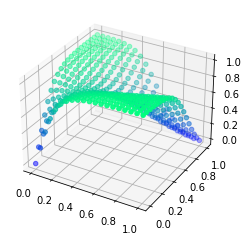

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


X = np.reshape([[0, 0], [0, 1], [1, 0], [1, 1]], (4, 2, 1))
Y = np.reshape([[0], [1], [1], [0]], (4, 1, 1))

network = [
    Dense(2, 3),
    Tanh(),
    Dense(3, 1),
    Tanh()
]

# train
train(network, mse, mse_prime, X, Y, epochs=10000, learning_rate=0.1)

# decision boundary plot
points = []
for x in np.linspace(0, 1, 20):
    for y in np.linspace(0, 1, 20):
        z = predict(network, [[x], [y]])
        points.append([x, y, z[0,0]])

points = np.array(points)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=points[:, 2], cmap="winter")
plt.show()